In [1]:
from dtcs.homogenous_crn.solution import *
from dtcs.homogenous_crn.sym import *
from dtcs.homogenous_crn.xps import *
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import seaborn as sb
import scipy.signal as signal
from mpl_toolkits.axes_grid1 import ImageGrid


# System Solving

In [2]:
# 1e-6_rt
sols = []
sm = SpeciesManager()

#[535.0 , 532.2 , 530.9 , 530.0 , 531.6 ,  531.6 ,  533.2, 535.0]
#[y1, x2, x3, x4, x53, x54, x6, x7]
y1 = sm.sp('y1', Orbital('1s', 535.0), {0:1.0000})
x2 = sm.sp('x2', Orbital('1s', 532.2), {0:0})
x3 = sm.sp('x3', Orbital('1s', 530.9), {0:0})
x4 = sm.sp('x4', Orbital('1s', 530.0), {0:0.25})
x53 = sm.sp('x53', Orbital('1s', 531.6), {0:0})
x54 = sm.sp('x54', Orbital('1s', 531.6), {0:0})
x6 = sm.sp('x6', Orbital('1s', 533.2), {0:0})
x7 = sm.sp('x7', Orbital('1s', 535.0), {0:0})

multipliers = [0.1, 0.5, 1, 5, 10]
default_rxn_consts = [1.238045, 0.526204, 6.220646, 0.160755, 0.299507, 0.167130, 0.794455, 0.199022, 0.300480, 0.127713, 0.400796, 0.394500, 0.000960, 76.964514]

In [3]:
# Test code that will be moved into a module
for i in range(len(default_rxn_consts)):
    for j in range(5):
        scaled = list(default_rxn_consts)
        scaled[i] *= multipliers[j]
        
        rsys = RxnSystem(
            Rxn(x4 + y1, x54, scaled[0]), # 0
            Rxn(x3 + y1, x53, scaled[1]), # 1
            Rxn(x54, x3 + x3, scaled[2]), # 2
            Rxn(x3 + x3, x54, scaled[3]), # 3
            Rxn(x53, x2 + x3, scaled[4]), # 4
            Rxn(x54, x2 + x4, scaled[5]), # 5
            Rxn(x2, y1, scaled[6]), # 6
            Rxn(y1, x2, scaled[7]), # 7
            Rxn(x53, y1 + x3, scaled[8]), # 8
            Rxn(x54, x4 + y1, scaled[9]), # 9
            Rxn(x53 + y1, x6, scaled[10]), # 10
            Rxn(x6, x53 + y1, scaled[11]), # 11
            Rxn(x4 + x4, x7, scaled[12]), # 12
            Rxn(x7, x4 + x4, scaled[13]), # 13
            sm
        )
        s = solve(rsys, time=10000)
        sols.append(s)
        print('Solved for ('+str(i)+', '+str(j)+')')
        print(scaled)
        print('\n')

KeyboardInterrupt: 

In [ ]:
import pickle
with open('../ag_regp_rt.pkl', 'wb') as f:
    pickle.dump(sols, f)

# Analysis

In [ ]:
sols = pickle.load(open('../data/ag_regp_rt.pkl', 'rb'))

In [ ]:
x = read_new_data('../data/ag_30e-3_25.txt', be=0)
j = 0
for i, s in enumerate(sols):
    j += 1
    j = j % len(multipliers)
    
    s.set_experimental(x[0])

In [9]:
for s in sols:
    s.ignore = [y1]
    s.process(gas_range=(534, 536))

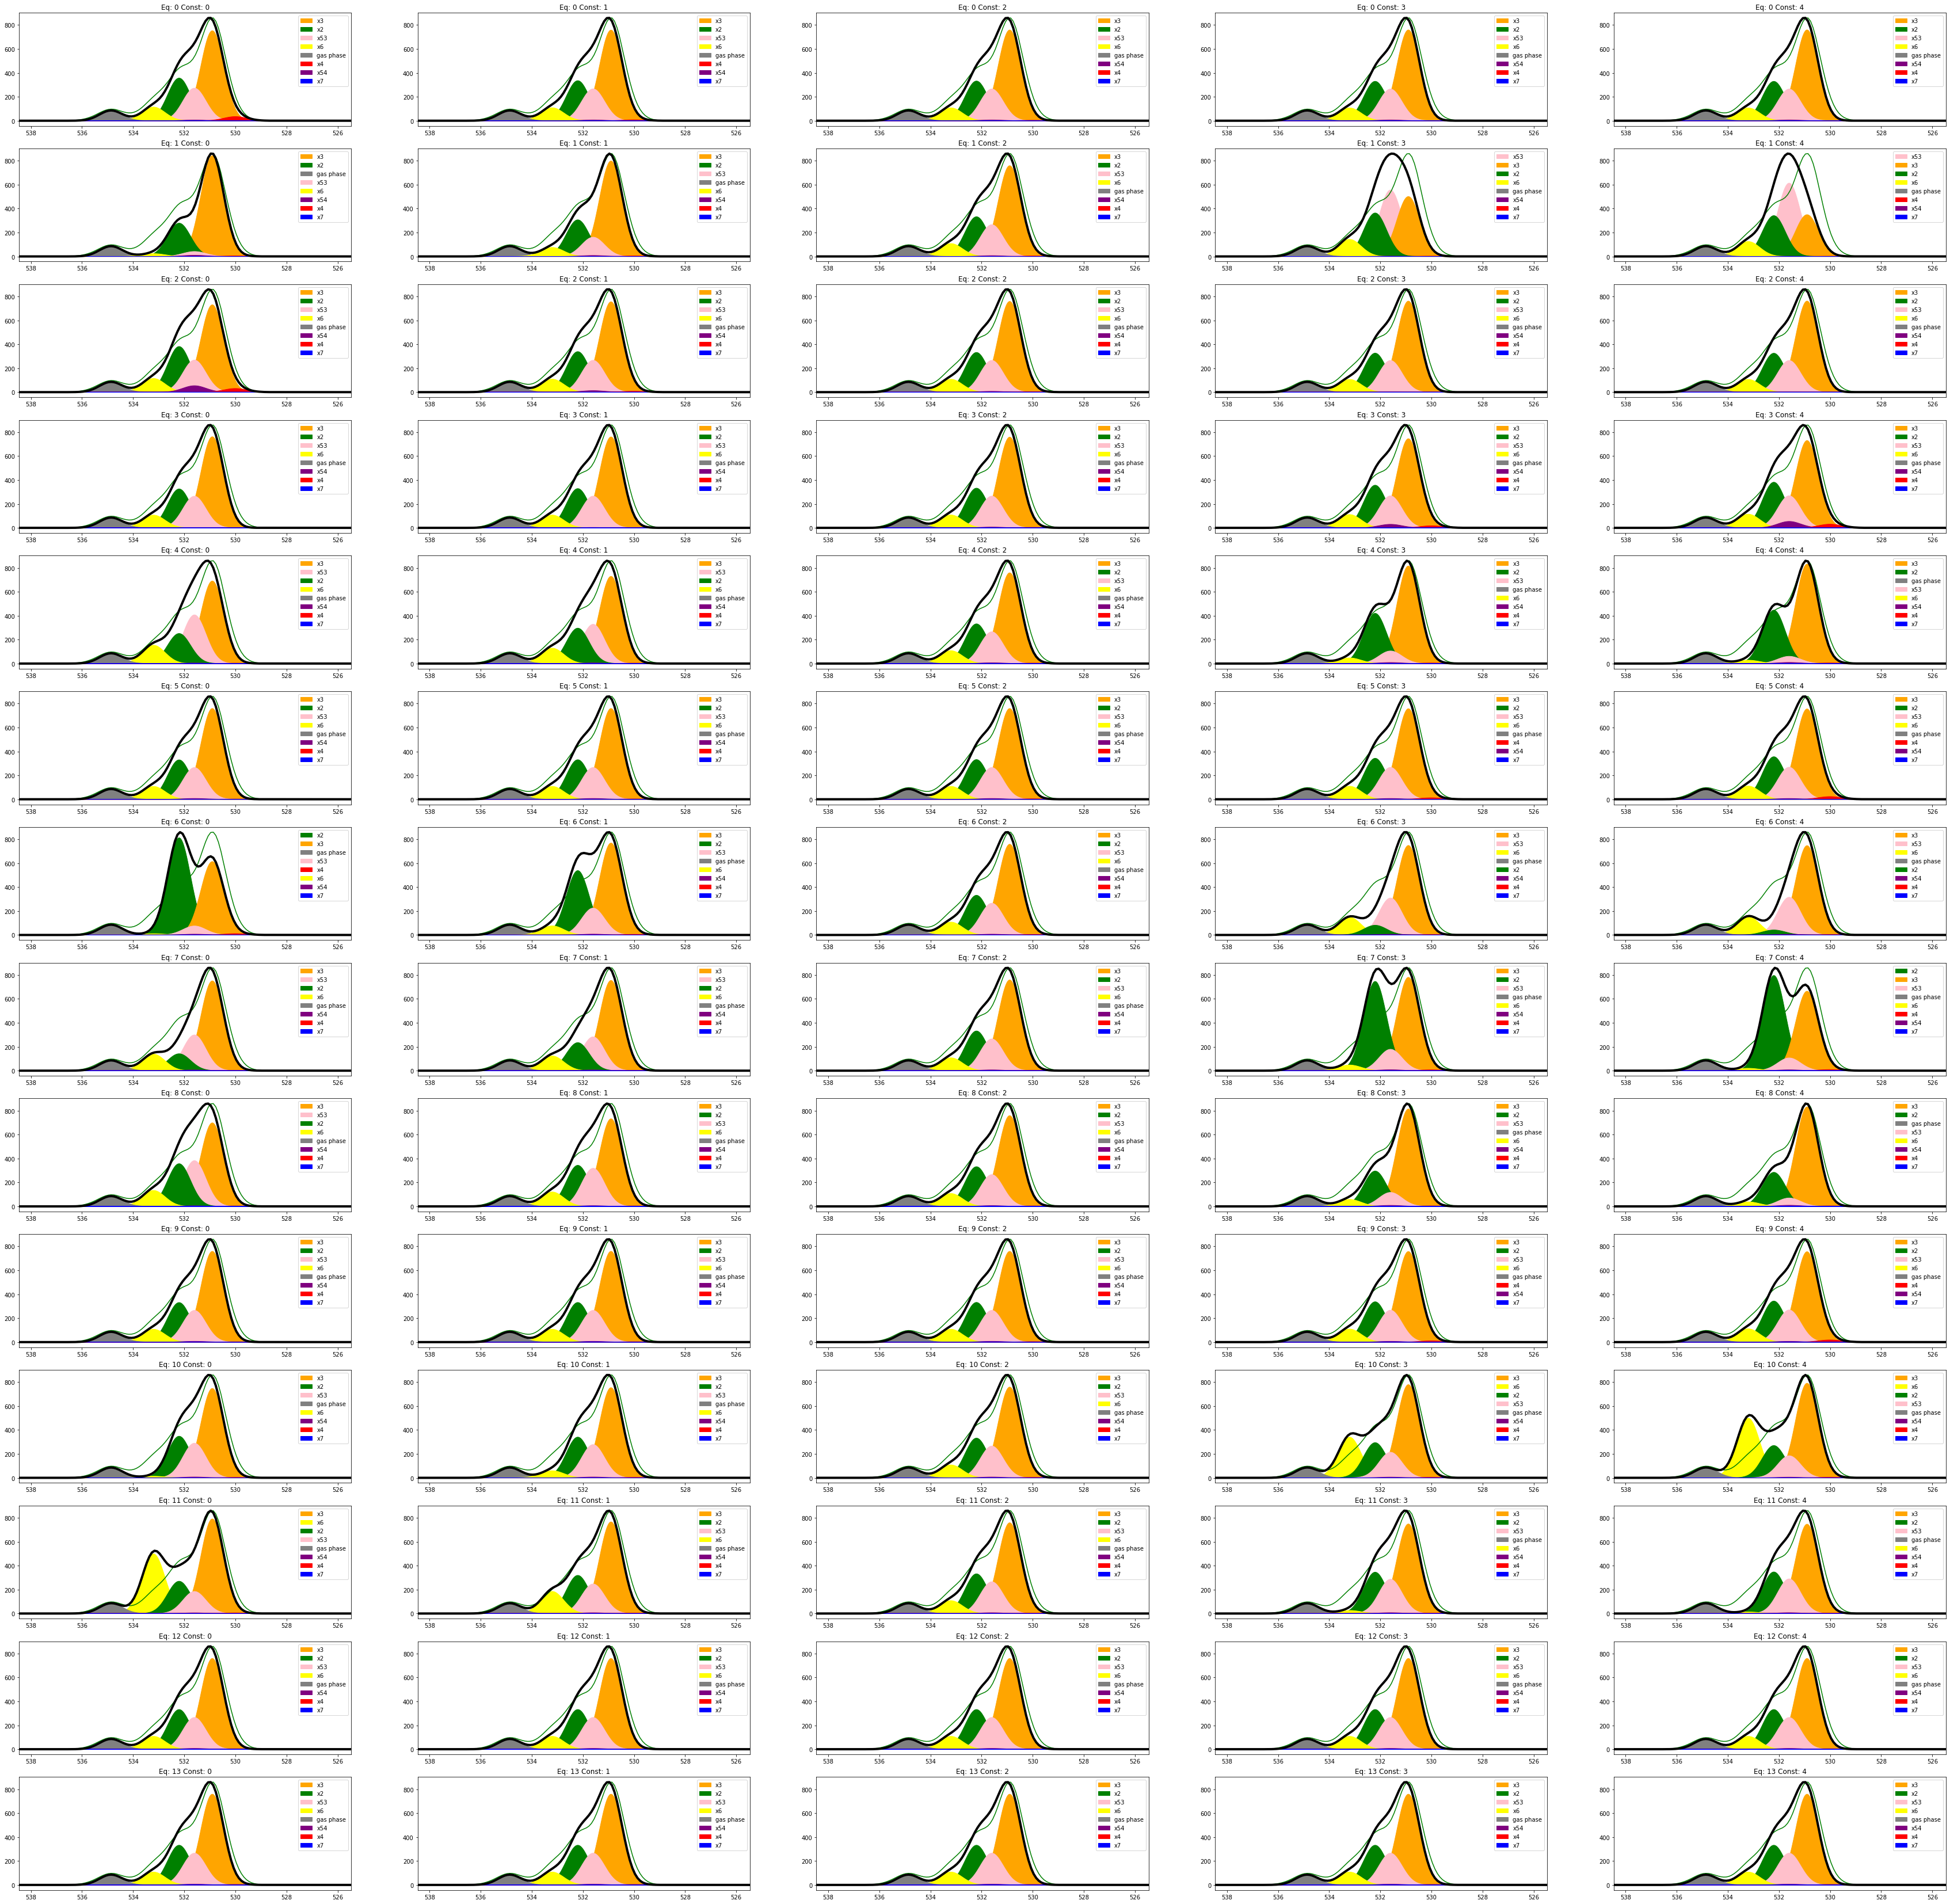

In [6]:
fig, axes = plt.subplots(nrows=14, ncols=5, figsize=(60,60))
for i in range(len(sols)):
    sols[i].plot_gaussian(envelope=True, resample_envelope=True, overlay=True, ax=axes[int(i/5), int(i%5)], title=('Eq: ' + str(int(i/5)) + ' Const: ' + str(i % 5)))
plt.show()

# RMSE

In [7]:
rmses_list = []
for i in range(len(default_rxn_consts)):
    rmses_list.append([])
    for j in range(5):
        rmses_list[i].append(sols[i*5 + j].rmse())
rmses = pd.DataFrame(rmses_list, columns=['0.1', '0.5', '1', '5', '10'])
rmses

,0.1,0.5,1,5,10
0,40.208415,42.171207,42.588409,42.955054,43.002899
1,62.252469,41.338914,42.588409,100.535269,120.586282
2,51.024265,43.189572,42.588409,42.249827,42.218322
3,42.217247,42.360039,42.588409,45.704184,51.024253
4,56.438175,47.950475,42.588409,39.844225,42.385725
5,42.790739,42.698590,42.588409,41.886362,41.425464
6,113.294306,65.095745,42.588409,62.801224,69.292998
7,53.963696,44.362013,42.588409,101.617493,107.747224
8,62.208259,50.199221,42.588409,46.954448,55.735211
9,42.763179,42.684779,42.588409,41.893428,41.198023


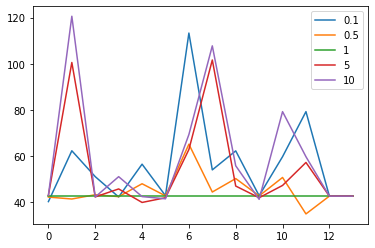

In [8]:
rmses.plot()

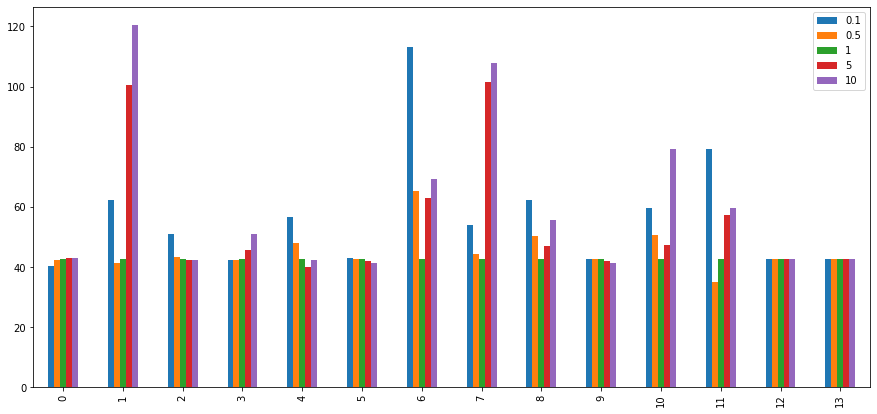

In [9]:
rmses.plot.bar(figsize=(15,7))

In [10]:
rmses_min = rmses.agg(['min', 'idxmin']).T
rmses_min

,min,idxmin
0.1,40.208415,0.0
0.5,34.870111,11.0
1,42.588409,0.0
5,39.844225,4.0
10,41.198023,9.0


0, 0.1


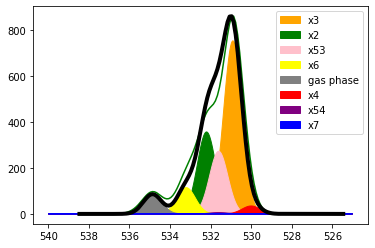

0, 1


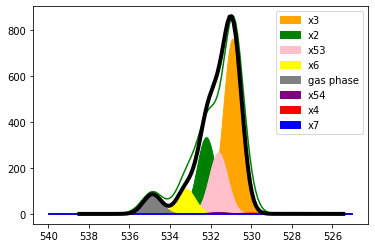

9, 10


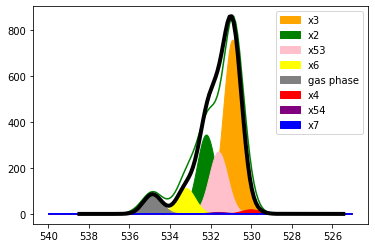

In [13]:
print('0, 0.1')
sols[0].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
print('0, 1')
sols[2].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
print('9, 10')
sols[49].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)

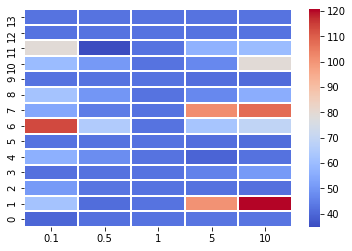

In [11]:
rmse_heatmap = sb.heatmap(rmses, cmap='coolwarm', linewidths=1)
rmse_heatmap.invert_yaxis()

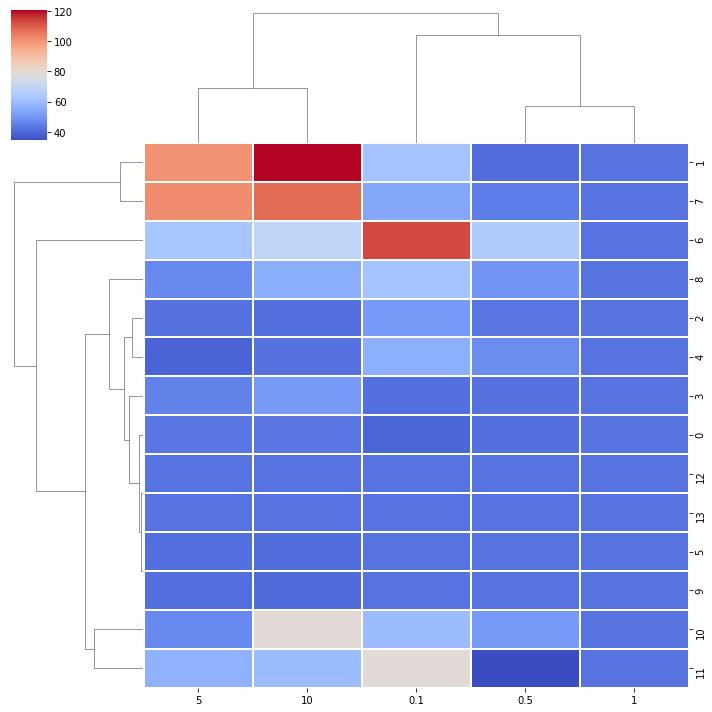

In [12]:
rmse_clustermap = sb.clustermap(rmses, cmap='coolwarm', linewidths=1)

## Between Integral Difference Comparison

In [10]:
integrals_list = []
for i in range(len(default_rxn_consts)):
    integrals_list.append([])
    for j in range(5):
        integrals_list[i].append(sols[i*5 + j].integral_diff_between())
integral_diffs = pd.DataFrame(integrals_list, columns=['0.1', '0.5', '1', '5', '10'])
integral_diffs

,0.1,0.5,1,5,10
0,303.683161,325.575317,329.114515,332.013439,332.379711
1,466.211017,309.191699,329.114515,631.262070,755.093410
2,364.690664,331.777831,329.114515,327.041027,326.780155
3,326.776082,327.824312,329.114515,342.809754,364.690602
4,391.807909,354.358547,329.114515,285.720663,306.114556
5,330.738692,330.013894,329.114515,322.735024,316.976006
6,768.019922,463.148865,329.114515,427.990213,453.747018
7,388.999247,340.952770,329.114515,633.756841,714.123897
8,425.043812,368.416121,329.114515,357.925820,422.887396
9,330.518872,329.893472,329.114515,323.039683,316.651428


In [11]:
integral_diffs_min = integral_diffs.agg(['min', 'idxmin']).T
integral_diffs_min

,min,idxmin
0.1,303.683161,0.0
0.5,239.054765,11.0
1,329.114515,0.0
5,285.720663,4.0
10,306.114556,4.0


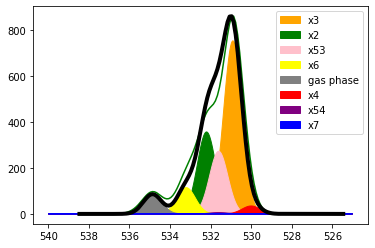

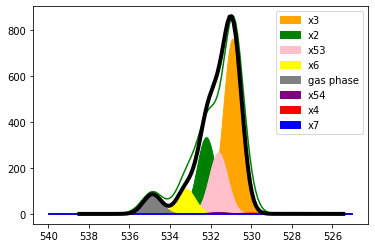

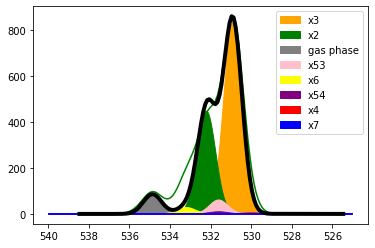

In [12]:
sols[0].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[2].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)
sols[24].plot_gaussian(envelope=True, overlay=True, resample_envelope=True)